# Model Analysis 

This program takes in datasets and models, and computes the loss landscapes over varying amounts of data.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import time
import glob

# Importing our existing funcs
import os
import sys
from pathlib import Path

from minima_volume.dataset_funcs import ( load_models_and_data )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [2]:
# User specifies the CIFAR-10 model module name
from minima_volume.models import CIFAR10_model_data as model_module  # <- your new module for CIFAR-10

# Generate dataset
#x_base, y_base, x_test, y_test = model_module.get_dataset(
#    device=device
#)

# CIFAR-10 MLP initialization parameters
# Since input dimension is higher, hidden layers can be larger
hidden_dims = [512, 256]  # adjust as desired

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=0)

# Grab loss and metrics
loss_fn_per_sample = model_module.get_loss_fn_per_sample()

## Loading Model and Datasets

In [3]:
# Get the relative path
target_dir = Path("models_and_data") #current directory

# Lists to store loaded models and additional data
loaded_models, loaded_additional_data, loaded_dataset = load_models_and_data(model_template=model_template, target_dir=target_dir, device="cpu")

# Print dataset information
print(f"Dataset type: {loaded_dataset['dataset_type']}")
print(f"Dataset quantities: {loaded_dataset['dataset_quantities']}")

# Print tensor shapes
print("\nTensor shapes:")
for key in ["x_base_train", "y_base_train", "x_additional", "y_additional", "x_test", "y_test"]:
    if loaded_dataset[key] is not None:
        print(f"  {key}: {loaded_dataset[key].shape}")
    else:
        print(f"  {key}: None")

Looking for models and dataset in: models_and_data
Found 5 model files:
  - model_additional_0.pt
  - model_additional_100.pt
  - model_additional_1000.pt
  - model_additional_2000.pt
  - model_additional_500.pt
✅ Model loaded into provided instance from models_and_data\model_additional_0.pt
Successfully loaded: model_additional_0.pt
✅ Model loaded into provided instance from models_and_data\model_additional_100.pt
Successfully loaded: model_additional_100.pt
✅ Model loaded into provided instance from models_and_data\model_additional_1000.pt
Successfully loaded: model_additional_1000.pt
✅ Model loaded into provided instance from models_and_data\model_additional_2000.pt
Successfully loaded: model_additional_2000.pt
✅ Model loaded into provided instance from models_and_data\model_additional_500.pt
Successfully loaded: model_additional_500.pt

Model data loaded from all models:
Model 0 (model_additional_0.pt):
  - Additional data: 0
  - Dataset type: poison
  - Training accuracies: 2000 e

✅ Dataset loaded from models_and_data\dataset.pt
Dataset type: poison
Dataset quantities: [0, 100, 500, 1000, 2000]

Tensor shapes:
  x_base_train: torch.Size([5000, 3, 32, 32])
  y_base_train: torch.Size([5000])
  x_additional: torch.Size([2000, 3, 32, 32])
  y_additional: torch.Size([2000])
  x_test: torch.Size([10000, 3, 32, 32])
  y_test: torch.Size([10000])


Base dataset size is  5000

Extracted data:
Model 0: Dataset size = 5000, Final test accuracy = 0.4141
Model 1: Dataset size = 5100, Final test accuracy = 0.4099
Model 2: Dataset size = 5500, Final test accuracy = 0.3914
Model 3: Dataset size = 6000, Final test accuracy = 0.3632
Model 4: Dataset size = 7000, Final test accuracy = 0.3275


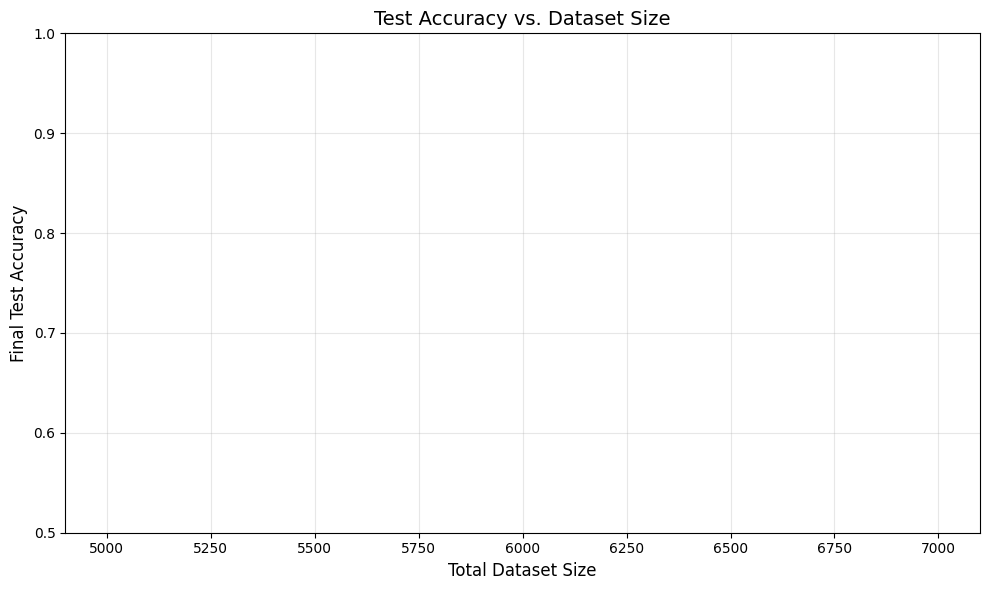


Summary statistics:
Number of models: 5
Dataset sizes range: 5000 to 7000
Accuracy range: 0.3275 to 0.4141
Mean accuracy: 0.3812

Saved data!


In [4]:
base_size = loaded_dataset['x_base_train'].shape[0]
print ("Base dataset size is ", base_size)

# Extract dataset sizes and final test accuracies
dataset_sizes = []
final_test_accuracies = []
for i, model_data in enumerate(loaded_additional_data):
    total_size = base_size + model_data['additional_data']
    final_test_accuracy = model_data['test_accs'][-1]
    dataset_sizes.append(total_size)
    final_test_accuracies.append(final_test_accuracy)

# Convert to numpy arrays for easier manipulation
dataset_sizes = np.array(dataset_sizes)
final_test_accuracies = np.array(final_test_accuracies)

sort_indices = np.argsort(dataset_sizes)
dataset_sizes = dataset_sizes[sort_indices]
final_test_accuracies = final_test_accuracies[sort_indices]

# Print the extracted data
print("\nExtracted data:")
for i, (size, acc) in enumerate(zip(dataset_sizes, final_test_accuracies)):
    print(f"Model {i}: Dataset size = {size}, Final test accuracy = {acc:.4f}")

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(dataset_sizes, final_test_accuracies, 'o-', markersize=8, linewidth=2)

# Customize the plot
plt.xlabel('Total Dataset Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Test Accuracy vs. Dataset Size', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim((0.5, 1.0))
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print(f"\nSummary statistics:")
print(f"Number of models: {len(dataset_sizes)}")
print(f"Dataset sizes range: {dataset_sizes.min()} to {dataset_sizes.max()}")
print(f"Accuracy range: {final_test_accuracies.min():.4f} to {final_test_accuracies.max():.4f}")
print(f"Mean accuracy: {final_test_accuracies.mean():.4f}")

# Save the arrays to a file
np.savez("test_accuracies.npz", dataset_sizes=dataset_sizes, final_test_accuracies=final_test_accuracies)
print(f"\nSaved data!")